# Part 2

## Imports

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.ensemble import RandomForestClassifier

## Read in CSV file

In [55]:
df = pd.read_csv('baseball_basketball.csv')
df.head()

,subreddit,selftext,title
0,baseball,NaN,[Bert Blyleven] (His wife was having surgery f...
1,baseball,NaN,[Bawfuls] Dodgers bullpen has an uncanny abili...
2,baseball,NaN,Signed baseball
3,baseball,NaN,On-field video of Ji-Man Choi's home run and C...
4,baseball,I took the liberty to make a simple scatterplo...,A damning visualization of Kershaw's postseaso...


## Preprocessing

In [56]:
df.drop(columns = ['selftext'], inplace = True)

In [57]:
df.head()

,subreddit,title
0,baseball,[Bert Blyleven] (His wife was having surgery f...
1,baseball,[Bawfuls] Dodgers bullpen has an uncanny abili...
2,baseball,Signed baseball
3,baseball,On-field video of Ji-Man Choi's home run and C...
4,baseball,A damning visualization of Kershaw's postseaso...


In [58]:
df['subreddit']

0         baseball
1         baseball
2         baseball
3         baseball
4         baseball
           ...    
1995    Basketball
1996    Basketball
1997    Basketball
1998    Basketball
1999    Basketball
Name: subreddit, Length: 2000, dtype: object

In [59]:
df['subreddit'] = df['subreddit'].map({'baseball': 0, 'Basketball': 1})

In [60]:
df['subreddit']

0       0
1       0
2       0
3       0
4       0
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Name: subreddit, Length: 2000, dtype: int64

## Getting rid of http, www, \n,  \n\n or # or @.

In [61]:
# From EC Local Flex NLP Tweets
df['title'] = df['title'].replace('\nhttp\S+', '', regex=True).replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n\S+', '', regex=True).replace('#\S+','', regex = True).replace('@\S+', '', regex=True)


In [62]:
df['title'].head(10)

0    [Bert Blyleven] (His wife was having surgery f...
1    [Bawfuls] Dodgers bullpen has an uncanny abili...
2                                      Signed baseball
3    On-field video of Ji-Man Choi's home run and C...
4    A damning visualization of Kershaw's postseaso...
5    Who do you think is the most overrated player ...
6        I'm starting for Illinois state finals today.
7    Ian Anderson's first career start (vs Cole): 6...
8    If you were an MLB exec, what would you do to ...
9    [Romero] LHP Kendri Yoelbis Rojas (17) has sig...
Name: title, dtype: object

## Remove punctuation

In [63]:
# From EC Local Flex NLP Tweets
def remove_punctuation(text):
    lower = text.lower()  
    exclude = string.punctuation
    return "".join(ch for ch in lower if ch not in exclude)

In [64]:
df['title'] = df['title'].apply(remove_punctuation)

## Porter Stemmer to remove suffixes and prefixes

In [65]:
# From EC Local Flex NLP Tweets
stemmer = PorterStemmer()
def split_and_stem(string):
    word = ""   
    string = string.split(' ')
    for i in string: 
        word += (stemmer.stem(i) + " ")  
    return word 

In [66]:
df['title'] = df['title'].apply(split_and_stem)

In [67]:
df['title'].head()

0    bert blyleven hi wife wa have surgeri for canc...
1    baw dodger bullpen ha an uncanni abil to allow...
2                                        sign basebal 
3    onfield video of jiman choi home run and carlo...
4         a damn visual of kershaw postseason perform 
Name: title, dtype: object

## Train Test Split

In [68]:
X = df['title']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 42,
                                                   stratify = y)

## Baseline Accuracy Score

In [69]:
y.value_counts(normalize = True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

## Count Vectorizer

In [70]:
cvec = CountVectorizer(stop_words='english')

In [71]:
X_train  = pd.DataFrame(cvec.fit_transform(X_train).todense(),
             columns=cvec.get_feature_names())

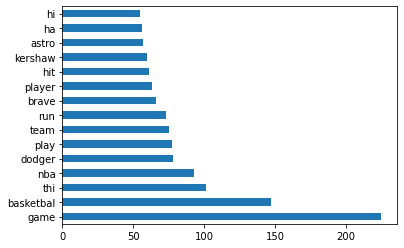

In [95]:
# Bar Chart of Top 10 occurring words
X_train.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.savefig('top_words.png');

In [73]:
len(X_train.columns)

2705

In [74]:
X_test  = pd.DataFrame(cvec.transform(X_test).todense(),
             columns=cvec.get_feature_names())

In [75]:
len(X_test.columns)

2705

## Logistic Regression Model

In [76]:
lr = LogisticRegression()

In [77]:
params = {
    'C': [0.4, 0.5, 0.6], 
    'penalty': ['l1'],
    'solver': ['liblinear']
}

In [78]:
gs = GridSearchCV(lr,
                 params,
                 cv = 5)

In [79]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.4, 0.5, 0.6], 'penalty': ['l1'],
                         'solver': ['liblinear']})

In [80]:
gs.best_params_

{'C': 0.6, 'penalty': 'l1', 'solver': 'liblinear'}

In [81]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.906, 0.858)

## Confusion Matrix For Logistic Regression Model

In [82]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

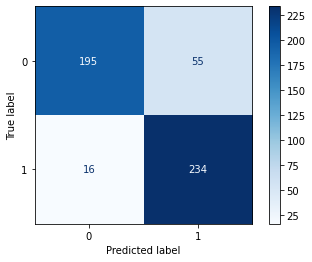

In [96]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d')
plt.savefig('lr_confusion_matrix.png');

In [84]:
# Specificity
tn / (tn + fp)

0.78

In [85]:
# Sensitivity
tp / (tp + fn)

0.936

## Building Random Forest Model

In [86]:
rf = RandomForestClassifier()

In [87]:
rf = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [75, 100, 125],
    'max_depth': [None, 3, 4],
    'max_features': ['auto', None]
}
gs_rf = GridSearchCV(rf, param_grid = params)
gs_rf.fit(X_train, y_train)


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 3, 4],
                         'max_features': ['auto', None],
                         'n_estimators': [75, 100, 125]})

In [88]:
gs_rf.best_params_

{'max_depth': None, 'max_features': 'auto', 'n_estimators': 125}

In [89]:
gs_rf.best_score_

0.8853333333333333

In [90]:
gs_rf.score(X_train, y_train), gs_rf.score(X_test, y_test)

(0.998, 0.904)

## Confusion Matrix for Random Forest Model

In [91]:
preds = gs_rf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

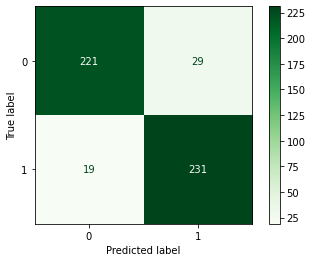

In [97]:
plot_confusion_matrix(gs_rf, X_test, y_test, cmap='Greens', values_format='d')
plt.savefig('rf_confusion_matrix.png');

In [93]:
# Specificity
tn / (tn + fp)

0.884

In [94]:
# Sensitivity
tp / (tp + fn)

0.924